# Space Craft Detection Model Using Transfer Learning
#### Author: Cody Ourique

In [15]:
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import shutil
import random
import os

PROJ_DIRECTORY = Path.cwd().parent
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
DEV_DIRECTORY = PROJ_DIRECTORY / "data_dev"
IMAGES_DIRECTORY_BALANCED = DEV_DIRECTORY / "balanced_images"
IMAGES_DIRECTORY_SOURCE = DEV_DIRECTORY / "images"
IMAGES_DIRECTORY_TRAIN = PROJ_DIRECTORY/ "notebooks/datasets/images/train"
IMAGES_DIRECTORY_VAL = PROJ_DIRECTORY/ "notebooks/datasets/images/val"
IMAGES_DIRECTORY_TEST = PROJ_DIRECTORY/ "notebooks/datasets/images/test"

### Data Exploration

In [3]:
train_meta = pd.read_csv(DEV_DIRECTORY / "metadata.csv", index_col="image_id")
train_labels = pd.read_csv(DEV_DIRECTORY / "labels.csv", index_col="image_id")

In [4]:
# we didn't download the full training set, so add a column indicating which images are saved locally
train_meta["exists"] = train_meta.index.to_series().map(lambda x: (IMAGES_DIRECTORY_TRAIN / f"{x}.png").exists())
# filter our metadata down to only the images we have locally
train_meta = train_meta[train_meta.exists]

train_meta.head()

,spacecraft_id,background_id,exists
image_id,,,
0001954c9f4a58f7ac05358b3cda8d20,24,247,True
00054819240f9d46378288b215dbcd3a,14,10,True
000dbf763348037b46558bbcb6a032ac,19,17,True
000e79208bebd8e84ce6c22fd8612a0d,14,15,True
000f13aff94499d03e3997afc55b0aa0,28,15,True


In [5]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def get_bbox(image_id, labels):
    """Get bbox coordinates as list from dataframe for given image id."""
    return labels.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values.tolist()

def display_image(image_id, images_dir=IMAGES_DIRECTORY_TRAIN, show_bbox=False, labels=train_labels):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir / f"{image_id}.png"))
    fig, ax = plt.subplots()
    # cv2 reads images as BGR order; we should flip them to RGB for matplotlib
    # ref: https://stackoverflow.com/questions/54959387/rgb-image-display-in-matplotlib-plt-imshow-returns-a-blue-image
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

Image size: (1280, 1024)


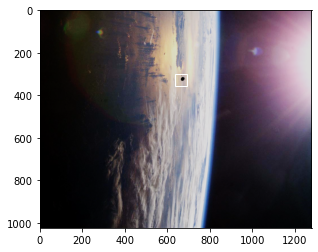

In [6]:
display_image("0a0ba7d4c31cd8c12e66f3e792a9599f", show_bbox=True)


image_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/images/train/0a0ba7d4c31cd8c12e66f3e792a9599f.png" 
image = Image.open(image_path)

# Get the size of the image
image_size = image.size

# Print the size of the image
print("Image size:", image_size)

In [13]:
train_metadata = pd.read_csv("../data_dev/metadata.csv")
spacecraft_ids = sorted(train_metadata['spacecraft_id'].unique())
print(spacecraft_ids)

print(len(train_metadata))
spacecraft_ids_count = train_metadata['spacecraft_id'].value_counts()
print(spacecraft_ids_count)

[2, 3, 5, 6, 11, 13, 14, 18, 19, 20, 22, 24, 25, 28, 30]
25801
spacecraft_id
28    2103
24    2096
25    2054
30    2012
18    1845
20    1833
19    1775
14    1725
6     1659
22    1640
11    1580
5     1515
3     1479
2     1287
13    1198
Name: count, dtype: int64


In [8]:
def scale_bbox_to_yolo_format(df_row, image_path):
    image = Image.open(image_path)
    width = image.size[0]
    height = image.size[1]
    # width = 1280
    # height = 1024

    # Calculate the center of the bounding boxes
    bbox_width = df_row["xmax"] - df_row["xmin"]
    bbox_height = df_row["ymax"] - df_row["ymin"]
    x_center = df_row["xmin"] + (bbox_width / 2.0)
    y_center = df_row["ymin"] + (bbox_height / 2.0)

    # Normalize coordinates
    x_center /= width
    y_center /= height

    bbox_width /= width
    bbox_height /= height

    return x_center, y_center, bbox_width, bbox_height

    

In [9]:
# Sample DataFrames (replace with your actual data)
df1 = train_metadata
df2 = train_labels

print(len(df1))
print(len(df2))
# Merge DataFrames on image_id (inner join)
merged_df = pd.merge(df1, df2, on='image_id', how='inner')

nan_count_rows = merged_df.isna().sum()
print(nan_count_rows)
print(merged_df.index.size)
# merged_df.dropna(inplace=True)
print(len(merged_df))
merged_df.tail(10)

25801
25801
image_id         0
spacecraft_id    0
background_id    0
xmin             0
ymin             0
xmax             0
ymax             0
dtype: int64
25801
25801


,image_id,spacecraft_id,background_id,xmin,ymin,xmax,ymax
25791,ffe63405a853e67940e4042b611b07a2,18,154,953,247,1077,346
25792,ffe6c765314141402040dd1366b2f0c4,28,236,48,5,744,539
25793,ffeb658bebeb21861c310f7365eb7cbe,11,150,283,0,1280,678
25794,ffeb84fd019ad4678e69f97e016d0003,13,2,770,851,782,865
25795,ffed50fcd56e8435ffedc1b66f98890e,25,7,209,42,252,303
25796,ffefb0578bfd52f492596e94b6e93568,11,10,302,599,441,720
25797,fff2c166a7807d6c2a738a3e0cd2accf,11,17,686,324,850,636
25798,fff56ebfd6d6ada3ce965eeaa81c871a,28,247,325,170,633,525
25799,fff6843668de441c20270bbd93479a1a,22,273,358,181,580,336
25800,fffb1f4bbf1d3d2bdb947f47e693ab0d,24,125,1153,691,1182,756


In [ ]:

def random_sample_spacecraft(df_spacecraft, value):
    sample = df_spacecraft.loc[df_spacecraft['spacecraft_id']==value].sample(n=350, random_state=42)
    return sample

def balance_spacecraft_classes(df_spacecraft):
    sample_list = []
    for i in spacecraft_ids:
      sample_list.append(random_sample_spacecraft(df_spacecraft, i))

    df_balanced = pd.concat(sample_list)
    return df_balanced

def reorganize_spacecraft_files(df_spacecraft, source_folder, destination_folder):
    for index, row in df_spacecraft.iterrows():
      # Get the image ID from the dataframe (replace 'image_id' with your actual column name)
      image_id = row["image_id"]

      # Construct the source and destination image paths
      source_image_path = os.path.join(source_folder, f"{image_id}.png")  # Adjust for your file format
      destination_image_path = os.path.join(destination_folder, f"{image_id}.png")

      if os.path.exists(source_image_path):
        # Copy the image from source to destination
        shutil.move(source_image_path, destination_image_path)
        print(f"Copied image: {image_id}.png")
      else:
        print(f"Image not found: {image_id}.png")

def split_train_test_val(source_dir, train_dir, val_dir, test_dir,train_ratio=0.8, val_ratio=0.1):
    for directory in [train_dir, val_dir, test_dir]:
      if not os.path.exists(directory):
          os.makedirs(directory)

    # Get list of filenames in the source directory
    filenames = os.listdir(source_dir)
    random.shuffle(filenames)

    # Calculate the number of samples for each set
    num_samples = len(filenames)
    num_train = int(num_samples * train_ratio)
    num_val = int(num_samples * val_ratio)

    # Assign filenames to each set
    train_filenames = filenames[:num_train]
    val_filenames = filenames[num_train:num_train+num_val]
    test_filenames = filenames[num_train+num_val:]

    # Copy files to respective directories
    for filename in train_filenames:
        shutil.copy(os.path.join(source_dir, filename), os.path.join(train_dir, filename))
    for filename in val_filenames:
        shutil.copy(os.path.join(source_dir, filename), os.path.join(val_dir, filename))
    for filename in test_filenames:
        shutil.copy(os.path.join(source_dir, filename), os.path.join(test_dir, filename))


df_spacecraft = balance_spacecraft_classes(merged_df)
reorganize_spacecraft_files(df_spacecraft, IMAGES_DIRECTORY_SOURCE, IMAGES_DIRECTORY_BALANCED)
split_train_test_val(IMAGES_DIRECTORY_SOURCE, IMAGES_DIRECTORY_TRAIN, IMAGES_DIRECTORY_VAL, IMAGES_DIRECTORY_TEST, 0.8, 0.1)


In [10]:
# Convert CSV to YOLO 

# File paths for data IO
labels_csv_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/data_dev/labels.csv"
train_images_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/images/train"  
val_images_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/images/val"  
train_output_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/train"  
val_output_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/val"
test_output_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/train"  
test_output_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/val"

# Function to convert a single CSV file to YOLOv8 format
def convert_csv_to_yolo(csv_file, images_path, output_path):
    # df_labels = pd.read_csv(csv_file)
    df_labels = merged_df
    spacecraft_ids_map = {}

    for i in range(len(spacecraft_ids)):
        spacecraft_ids_map[spacecraft_ids[i]] = i

    # Verify that the values are correctly stored in the map
    print(spacecraft_ids_map)

    for index, row in df_labels.iterrows():
        
        file_path = os.path.join(images_path, row["image_id"] + ".png")
        if not os.path.exists(file_path):
            continue
        
        x_center, y_center, bbox_width, bbox_height = scale_bbox_to_yolo_format(row, file_path)
        print(f'x_center: {x_center}, y_center: {y_center}, bbox_width: {bbox_width}, bbox_height: {bbox_height}')     
        
        output_file = os.path.join(output_path, row["image_id"] + ".txt")
        with open(output_file, "w") as f:
            f.write(f"{spacecraft_ids_map.get(row['spacecraft_id'])} {x_center} {y_center} {bbox_width} {bbox_height}")
   

convert_csv_to_yolo(labels_csv_path, train_images_path, train_output_path)
convert_csv_to_yolo(labels_csv_path, val_images_path, val_output_path)

{2: 0, 3: 1, 5: 2, 6: 3, 11: 4, 13: 5, 14: 6, 18: 7, 19: 8, 20: 9, 22: 10, 24: 11, 25: 12, 28: 13, 30: 14}
x_center: 0.134765625, y_center: 0.4814453125, bbox_width: 0.26953125, bbox_height: 0.421875
x_center: 0.658203125, y_center: 0.64794921875, bbox_width: 0.13984375, bbox_height: 0.1201171875
x_center: 0.141796875, y_center: 0.44677734375, bbox_width: 0.03359375, bbox_height: 0.0458984375
x_center: 0.109765625, y_center: 0.546875, bbox_width: 0.11015625, bbox_height: 0.05078125
x_center: 0.162109375, y_center: 0.09423828125, bbox_width: 0.16328125, bbox_height: 0.1884765625
x_center: 0.737109375, y_center: 0.4482421875, bbox_width: 0.05078125, bbox_height: 0.138671875
x_center: 0.946484375, y_center: 0.56640625, bbox_width: 0.10703125, bbox_height: 0.8671875
x_center: 0.33203125, y_center: 0.14892578125, bbox_width: 0.1578125, bbox_height: 0.2978515625
x_center: 0.784765625, y_center: 0.07421875, bbox_width: 0.11640625, bbox_height: 0.076171875
x_center: 0.91015625, y_center: 0.590

In [11]:
from ultralytics import YOLO
from ultralytics.data.utils import check_det_dataset

data = check_det_dataset("data.yaml")
names = data["names"]
print(names)
print(len(names))

# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch
# model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data="data.yaml", epochs=1)  # train the model
# metrics = model.val()  # evaluate model performance on the validation set
# # results = model("https://ultralytics.com/images/bus.jpg")  # predict on an image
# path = model.export(format="onnx")  # export the model to ONNX format

{0: '2', 1: '3', 2: '5', 3: '6', 4: '11', 5: '13', 6: '14', 7: '18', 8: '19', 9: '20', 10: '22', 11: '24', 12: '25', 13: '28', 14: '30'}
15
Ultralytics YOLOv8.2.12 🚀 Python-3.8.5 torch-2.1.0 CPU (Intel Core(TM) i9-9980HK 2.40GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train52, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, emb

train: Scanning /Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/train... 1579 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1579/1579 [00:11<00:00, 141.23it/s]

train: New cache created: /Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/train.cache



val: Scanning /Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/val... 1557 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1557/1557 [00:11<00:00, 131.04it/s]

val: New cache created: /Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/val.cache


Plotting labels to runs/detect/train52/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train52
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      3.784      7.424      4.322         19        640: 100%|██████████| 99/99 [15:52<00:00,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [05:31<00:00,  6.77s/it]


                   all       1557       1557    1.4e-05   0.000673   8.34e-06   8.34e-07

1 epochs completed in 0.359 hours.
Optimizer stripped from runs/detect/train52/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train52/weights/best.pt, 6.2MB

Validating runs/detect/train52/weights/best.pt...
Ultralytics YOLOv8.2.12 🚀 Python-3.8.5 torch-2.1.0 CPU (Intel Core(TM) i9-9980HK 2.40GHz)
YOLOv8n summary (fused): 168 layers, 3008573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [04:55<00:00,  6.02s/it]


                   all       1557       1557   1.16e-05    0.00202   7.54e-06   1.35e-06
                     2       1557         75          0          0          0          0
                     3       1557         87          0          0          0          0
                     5       1557         88          0          0          0          0
                     6       1557         88          0          0          0          0
                    11       1557        108          0          0          0          0
                    13       1557         62          0          0          0          0
                    14       1557        106          0          0          0          0
                    18       1557         99   0.000174     0.0303   0.000113   2.03e-05
                    19       1557        103          0          0          0          0
                    20       1557        106          0          0          0          0
                    2